<a href="https://colab.research.google.com/github/timuriz/ObjectSegmentationMarsWS25/blob/main/path_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations==1.4.6 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.models.segmentation as models
import torch.nn as nn
import torch

In [ ]:
class RoadBaseDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        # список имён файлов картинок
        self.image_names = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, name)
        mask_path = os.path.join(self.masks_dir, name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))
        return image, mask

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

IMG_SIZE = 768

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=25,
        p=0.8,
        border_mode=0
    ),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

class IndexedRoadDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset      # ВАЖНО: здесь будет RoadBaseDataset
        self.indices = indices                # список индексов (train или val)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        name = self.base_dataset.image_names[idx]

        img_path = os.path.join(self.base_dataset.images_dir, name)
        mask_path = os.path.join(self.base_dataset.masks_dir, name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        mask = (mask > 0).astype("float32")

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"].float()
        mask  = augmented["mask"].unsqueeze(0).float()

        return image, mask

In [ ]:
images_dir = "/content/image"
masks_dir  = "/content/mask"

# 1) создаём базовый датасет
base_dataset = RoadBaseDataset(images_dir, masks_dir)

print("len(base_dataset):", len(base_dataset))

# тест базового датасета
img0, m0 = base_dataset[0]
print("base_dataset[0] image:", type(img0), img0.shape)
print("base_dataset[0] mask: ", type(m0),  m0.shape)

# 2) делим индексы вручную на train/val
n = len(base_dataset)
n_train = int(0.8 * n)
indices = list(range(n))

train_indices = indices[:n_train]
val_indices   = indices[n_train:]

print("train_indices:", train_indices)
print("val_indices:  ", val_indices)

# 3) создаём train/val датасеты с трансформами
train_ds = IndexedRoadDataset(base_dataset, train_indices, train_transform)
val_ds   = IndexedRoadDataset(base_dataset, val_indices,   val_transform)

print("len(train_ds):", len(train_ds))
print("len(val_ds):  ", len(val_ds))

# тест train_ds
img1, m1 = train_ds[0]
print("train_ds[0] image:", img1.shape)
print("train_ds[0] mask: ", m1.shape)

# 4) DataLoader'ы
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=0)

len(base_dataset): 23
base_dataset[0] image: <class 'numpy.ndarray'> (720, 1280, 3)
base_dataset[0] mask:  <class 'numpy.ndarray'> (720, 1280)
train_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
val_indices:   [18, 19, 20, 21, 22]
len(train_ds): 18
len(val_ds):   5
train_ds[0] image: torch.Size([3, 768, 768])
train_ds[0] mask:  torch.Size([1, 768, 768])


In [ ]:
pip install torch torchvision

In [ ]:
def create_model():
    # загружаем предобученную модель
    model = models.deeplabv3_resnet50(weights=models.DeepLabV3_ResNet50_Weights.DEFAULT)

    # заменяем финальный слой: 256 каналов -> 1 (дорога)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

    return model

model = create_model().to(device)

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # preds: сырые логицы [B,1,H,W]
        preds = torch.sigmoid(preds)

        # приводим всё к вектору
        preds_flat = preds.view(preds.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        intersection = (preds_flat * targets_flat).sum(dim=1)
        union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)

        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        loss = 1.0 - dice  # [B]
        return loss.mean()

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def loss_fn(outputs, masks):
    return bce_loss(outputs, masks) + 0.7 * dice_loss(outputs, masks)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = loss_fn(outputs, masks)

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = eval_one_epoch(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

Epoch 1/50 | train loss: 1.2859 | val loss: 1.1026
Epoch 2/50 | train loss: 1.1087 | val loss: 0.8265
Epoch 3/50 | train loss: 0.9917 | val loss: 0.8522
Epoch 4/50 | train loss: 0.9368 | val loss: 0.8399
Epoch 5/50 | train loss: 0.8894 | val loss: 0.7339
Epoch 6/50 | train loss: 0.8549 | val loss: 0.7053
Epoch 7/50 | train loss: 0.8191 | val loss: 0.6853
Epoch 8/50 | train loss: 0.7873 | val loss: 0.9618
Epoch 9/50 | train loss: 0.7730 | val loss: 0.9318
Epoch 10/50 | train loss: 0.7462 | val loss: 0.9246
Epoch 11/50 | train loss: 0.7157 | val loss: 0.9049
Epoch 12/50 | train loss: 0.6894 | val loss: 2.7746
Epoch 13/50 | train loss: 0.6641 | val loss: 1.8035
Epoch 14/50 | train loss: 0.6520 | val loss: 2.1698
Epoch 15/50 | train loss: 0.6383 | val loss: 0.9525
Epoch 16/50 | train loss: 0.6415 | val loss: 0.7101
Epoch 17/50 | train loss: 0.6077 | val loss: 0.6372
Epoch 18/50 | train loss: 0.5789 | val loss: 0.6121
Epoch 19/50 | train loss: 0.5599 | val loss: 0.6332
Epoch 20/50 | train l

=== Sample 0 ===


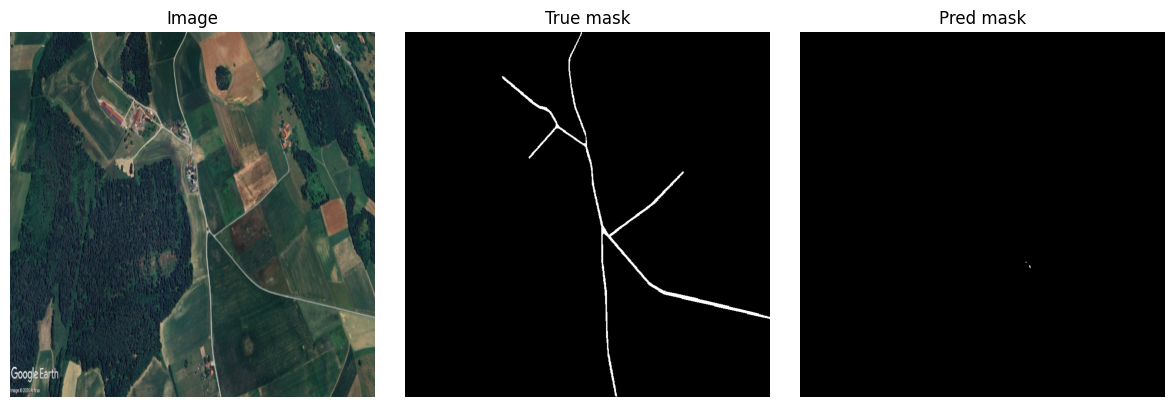

=== Sample 1 ===


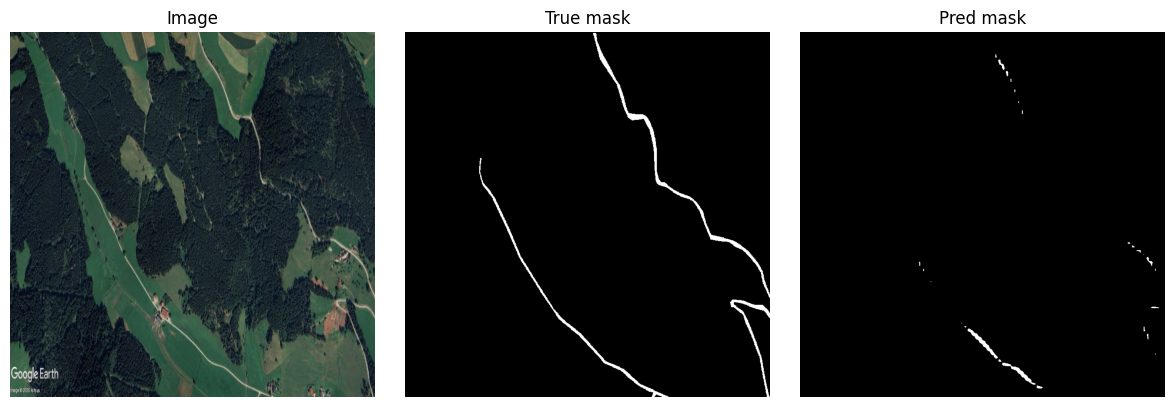

=== Sample 2 ===


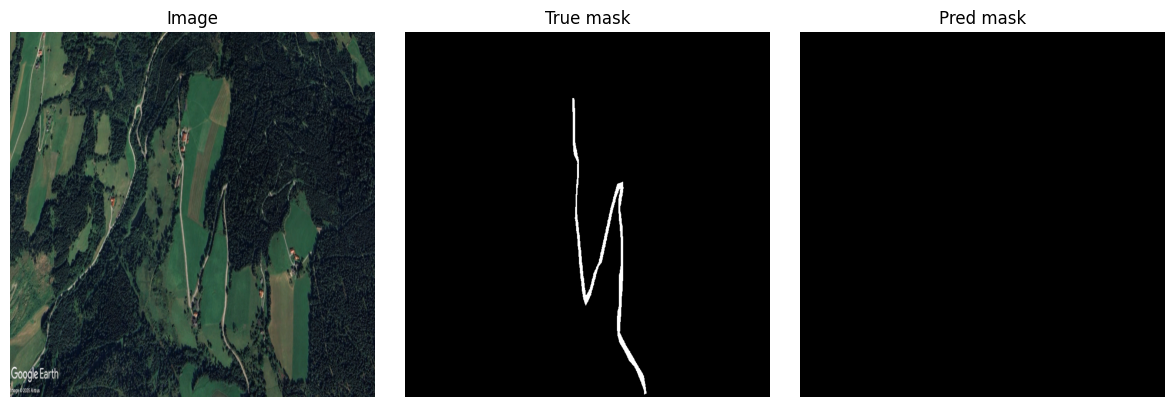

=== Sample 3 ===


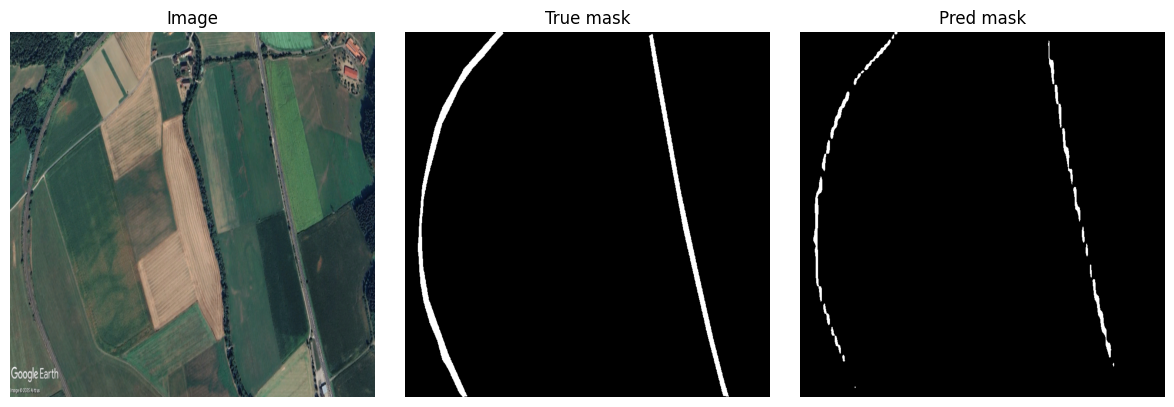

=== Sample 4 ===


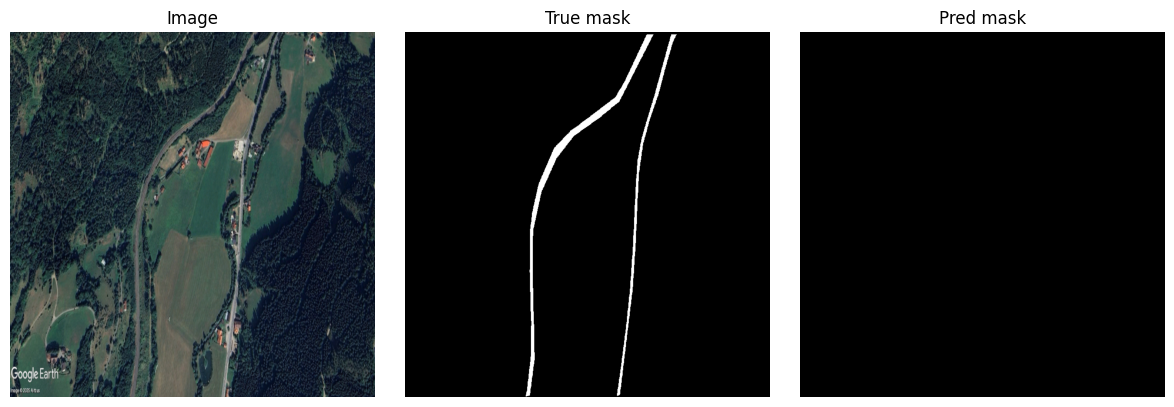

=== Sample 5 ===


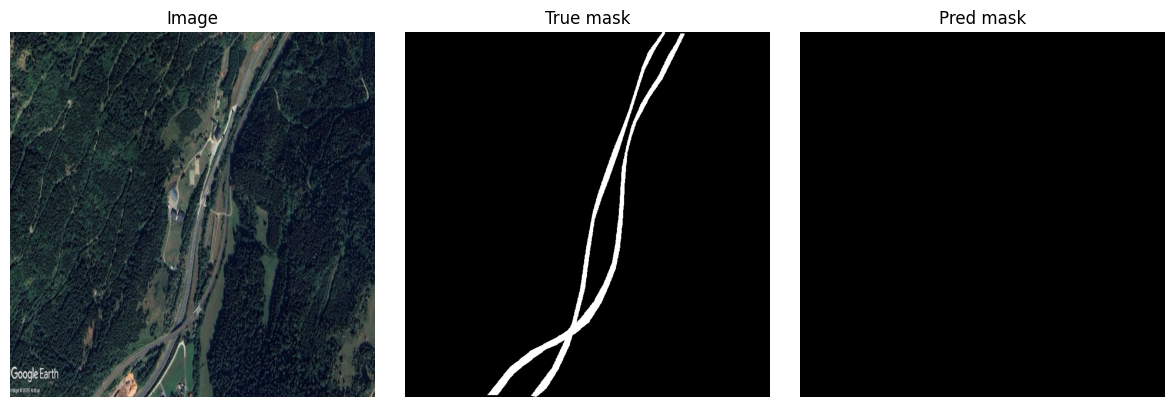

=== Sample 6 ===


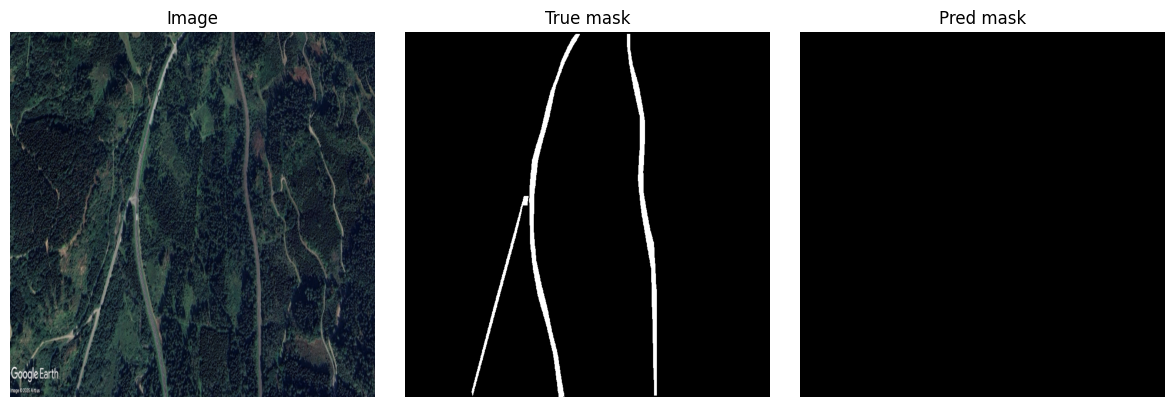

=== Sample 7 ===


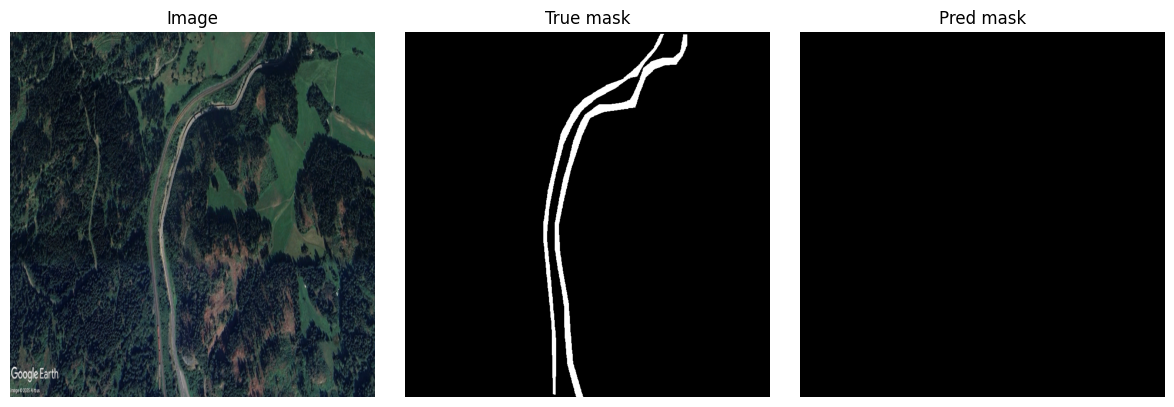

=== Sample 8 ===


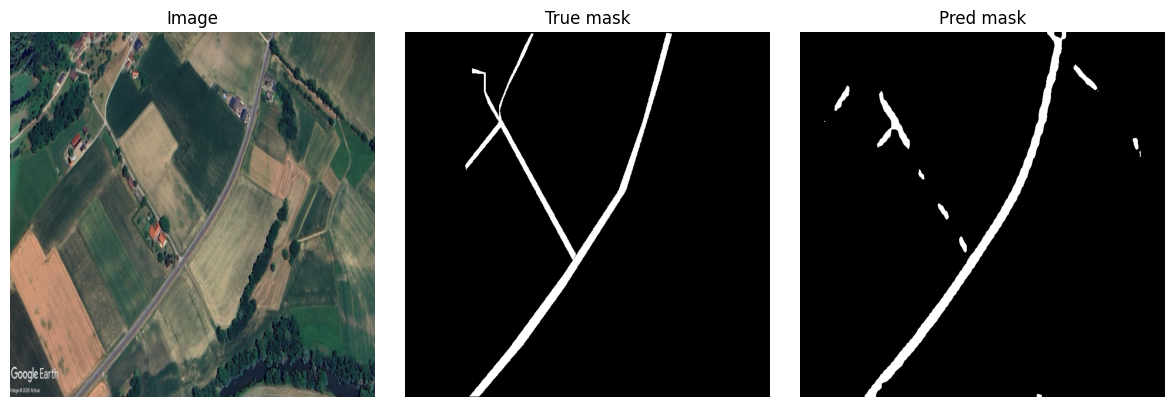

=== Sample 9 ===


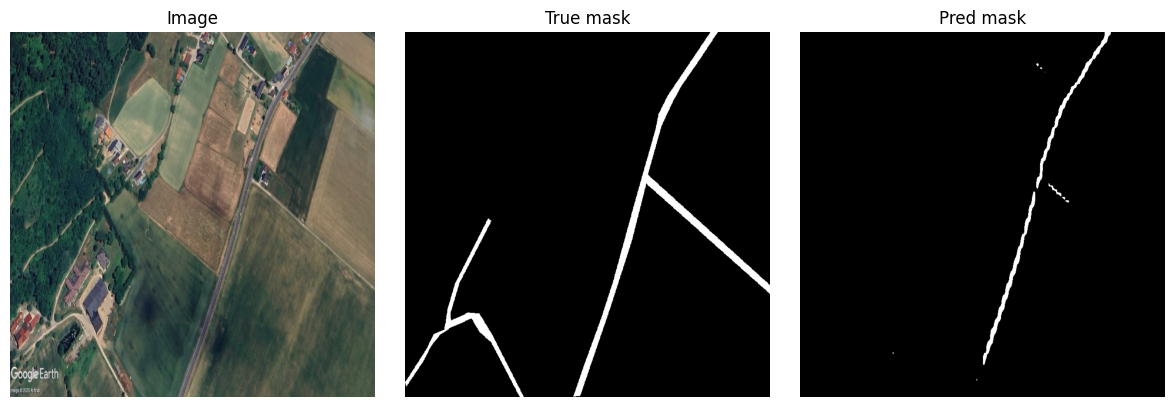

=== Sample 10 ===


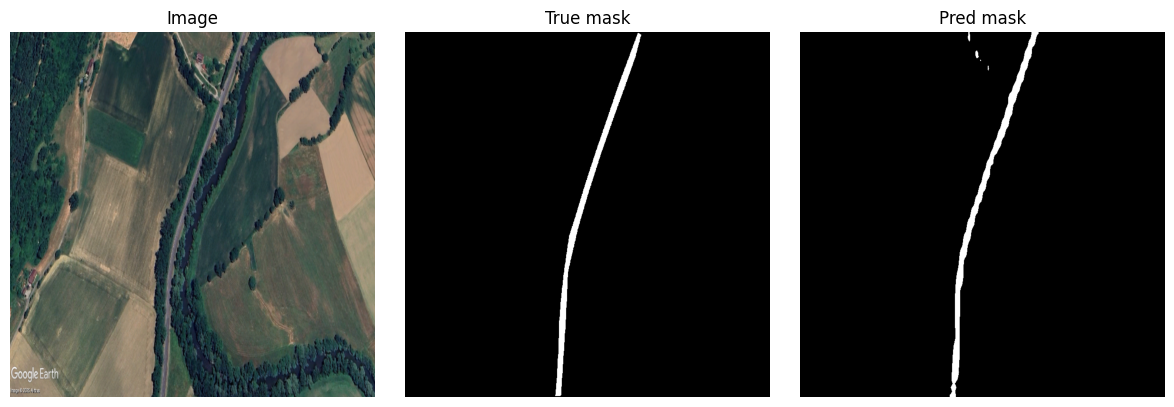

=== Sample 11 ===


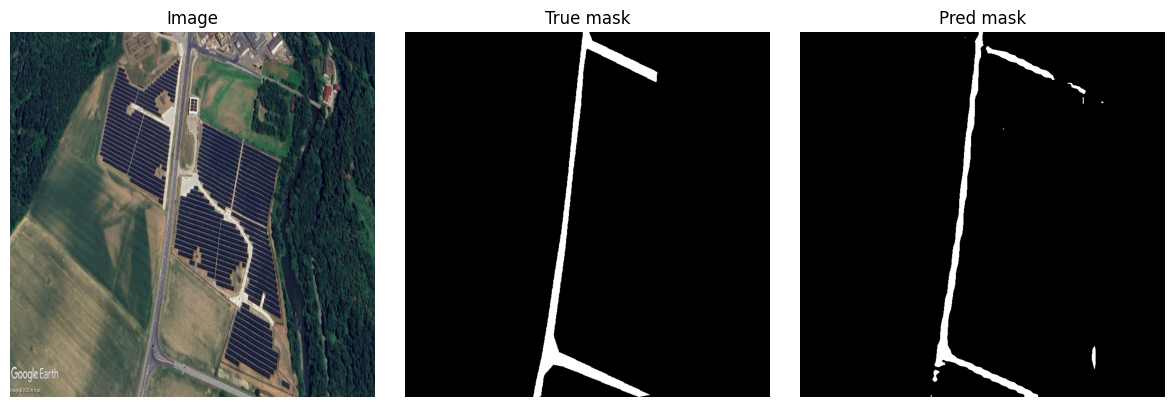

=== Sample 12 ===


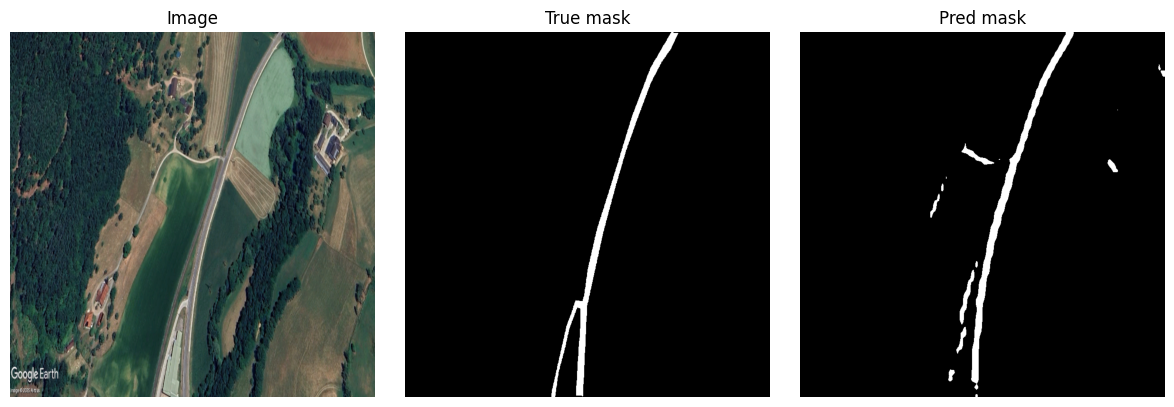

=== Sample 13 ===


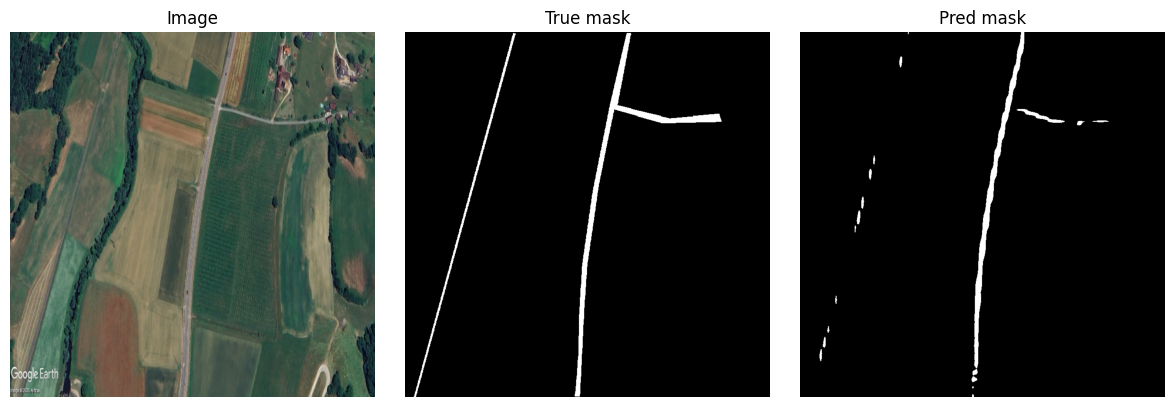

=== Sample 14 ===


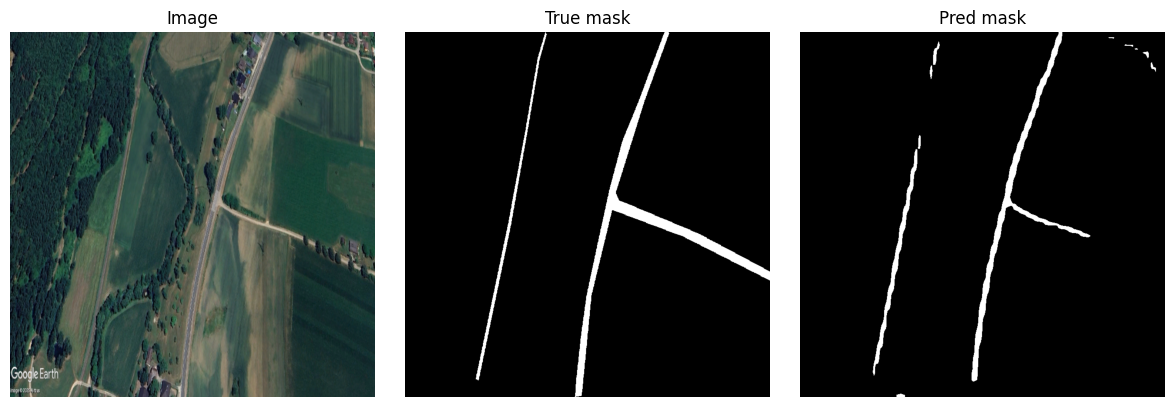

=== Sample 15 ===


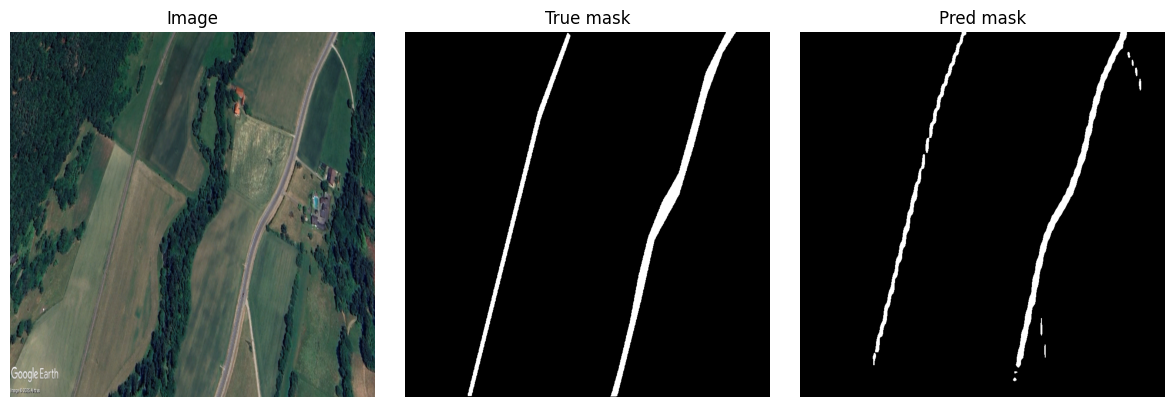

=== Sample 16 ===


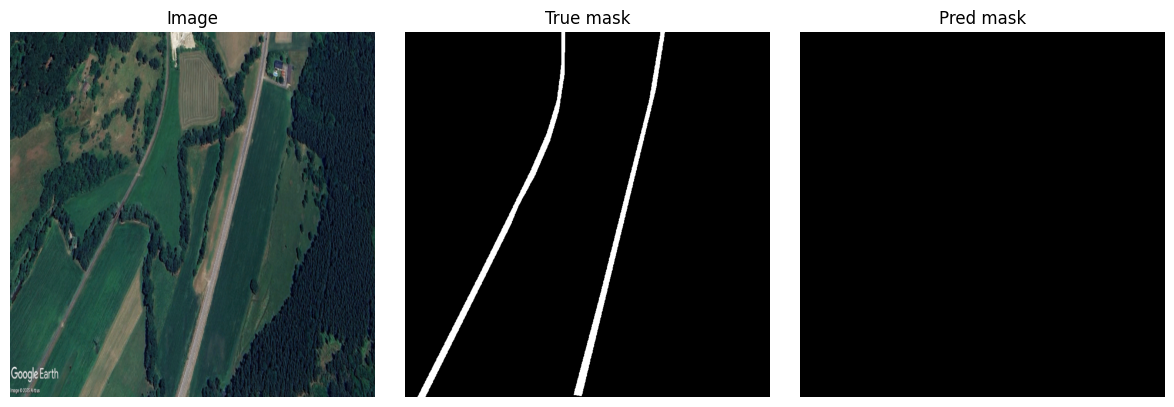

=== Sample 17 ===


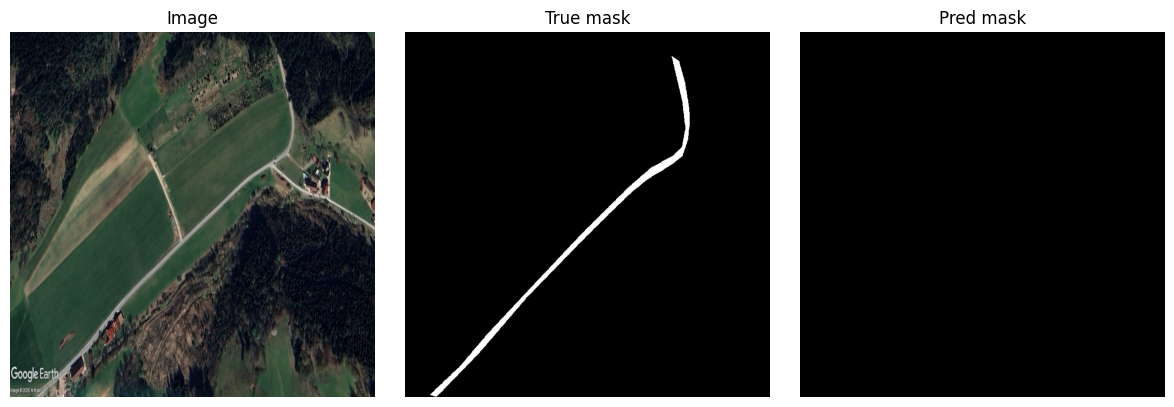

=== Sample 18 ===


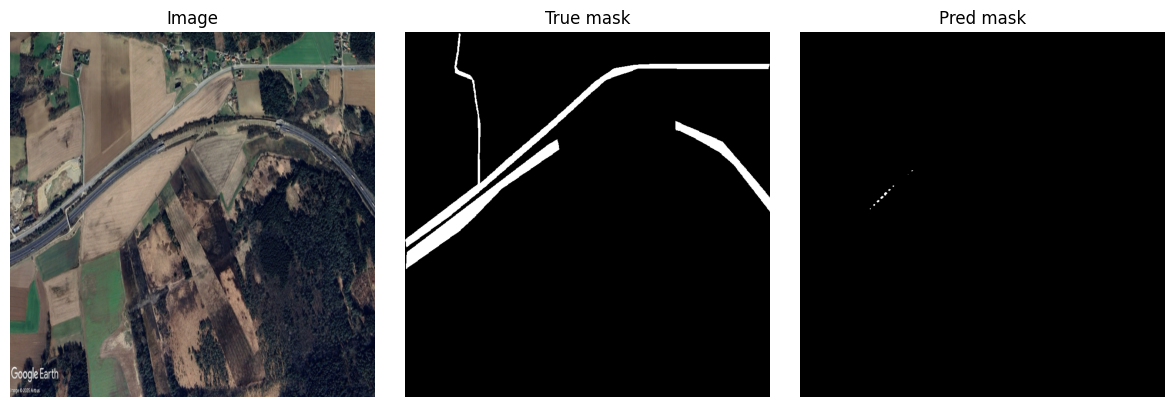

=== Sample 19 ===


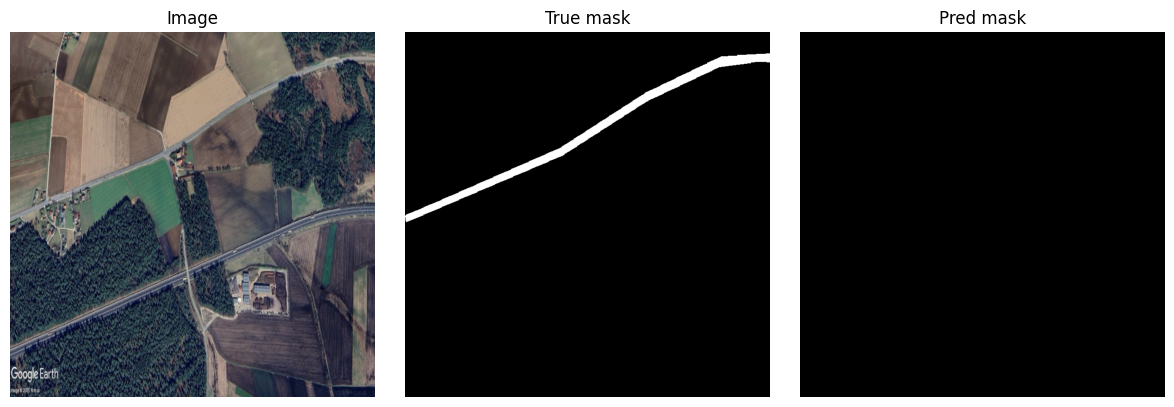

=== Sample 20 ===


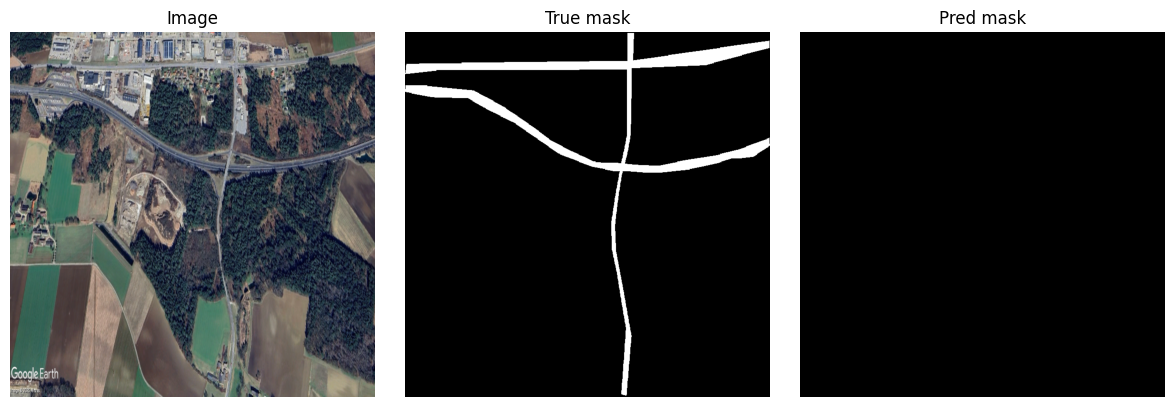

=== Sample 21 ===


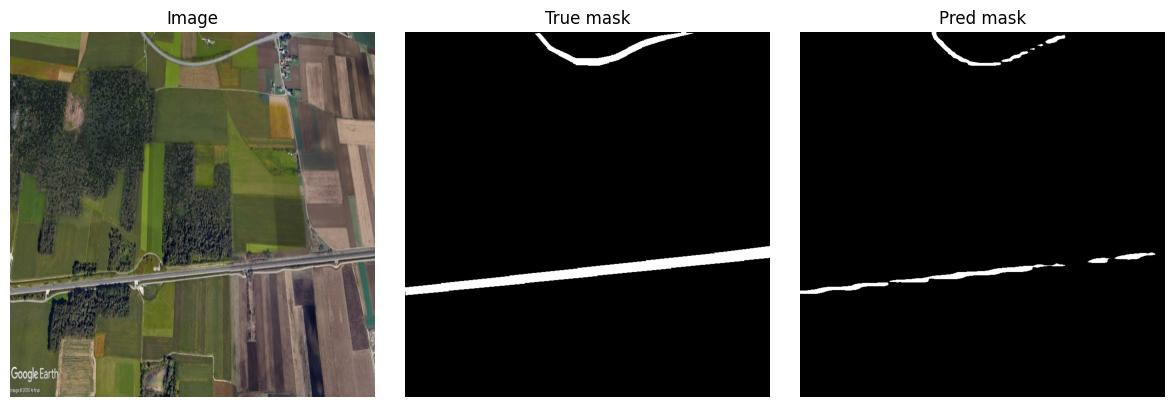

=== Sample 22 ===


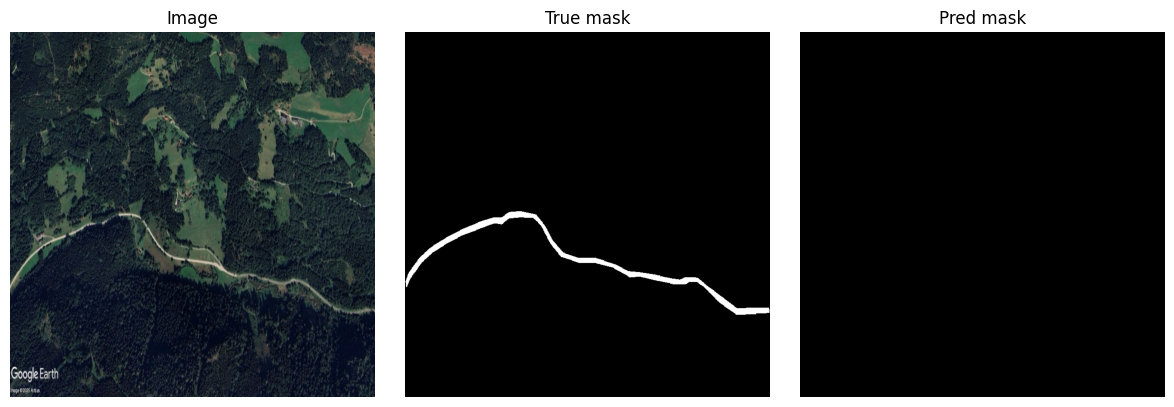

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_sample(model, dataset, idx=0, device=device, threshold=0.4):
    model.eval()
    image, mask_true = dataset[idx]
    image_batch = image.unsqueeze(0).to(device)

    output = model(image_batch)["out"]  # [1,1,H,W]
    prob = torch.sigmoid(output)[0,0].cpu()  # [H,W]
    pred_mask = (prob > threshold).float()

    # в numpy
    img_np = image.permute(1,2,0).cpu().numpy()
    img_vis = img_np * 0.5 + 0.5        # возвращаем в диапазон [0,1]
    img_vis = np.clip(img_vis, 0, 1)
    true_np = mask_true[0].cpu().numpy()
    pred_np = pred_mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(img_vis)
    axs[0].set_title("Image")
    axs[1].imshow(true_np, cmap="gray")
    axs[1].set_title("True mask")
    axs[2].imshow(pred_np, cmap="gray")
    axs[2].set_title("Pred mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# полный датасет для визуализации всех изображений разом
full_ds = IndexedRoadDataset(base_dataset, list(range(len(base_dataset))), val_transform)

for i in range(len(full_ds)):
    print(f"=== Sample {i} ===")
    visualize_sample(model, full_ds, idx=i, threshold=0.4)